
train NNDF
=======

Proof-of-concept to train an ANN model on a computational fluid dynamics (CFD) solution (incompressible finite difference solution on Cartesian homogeneous mesh, immersed boundary, fractional step method).

Concept
-------
The key idea is that the cell update is a local problem adhering to the conservation of mass, momentum, and energy. This is typically decribed by a local discretization of the differential or integral conservation equations, involving a local stencil (pattern of cells) surrounding the cell of interest to compute the time advancement. The key idea here is to have these functions learned by a neural net, without spelling them out.

In this sense, it can be understood as a poor-man's convolutional neureal net, in that the stencil is applied to cells with a stride of one. Here, there is only one complex filter acting at all cells. The dimensionality is given by the number of variables; in the 2D case regarded here this amounts to the x and y components of the velocity vector, and the marker function distinguishing a fluid from a solid cell.

The training data set treats all sets of cell, stencil, and value in next time-step identically.


Current state
------------
The subsequent step can be predicted with an error of $\approx 4.0\times 10^{-6}$ compared to the CFD solution.

I/O
---
- In: reads data from `traindata.dat`, prepared by `prepdata.ipynb`
- Out: writes model into `NNFD_norm_1.3e-3.pt` and standardization parameters into `stdfile.dat`

TODO
----
- online comparison with validation data to avoid overfitting
- reduce error of trained network (symmetries, training data, periodic case)
- reduce required stencil size
- minimize ANN size
- incorporate more into NN atrchitecture rather than poor-man's procedure used herein
- include conservation laws directly in loss function

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch


In [34]:
# YtestDf = pd.read_csv("traindatashort.dat", sep = ' ',usecols=['Up','Wp'])
# XtestDf = pd.read_csv("traindatashort.dat",sep=' ', usecols=['U','W','U0','W0','U1','W1',
#                                                             'U2','W2','U3','W3','U4','W4',
#                                                             'U5','W5','U6','W6','U7','W7',
#                                                               'isfluid'])

YtruthDf = pd.read_csv("traindatasym.dat", sep = ' ',usecols=['Up','Wp'])
XtruthDf = pd.read_csv("traindatasym.dat",sep=' ', usecols=['U','W','U0','W0','U1','W1',
                                                            'U2','W2','U3','W3','U4','W4',
                                                            'U5','W5','U6','W6','U7','W7',
                                                            'isfluid'])

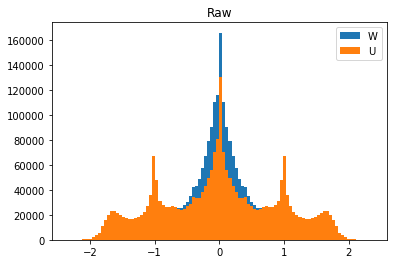

U
0.0
0.9109369802195609
W
0.0
0.7087137512219893


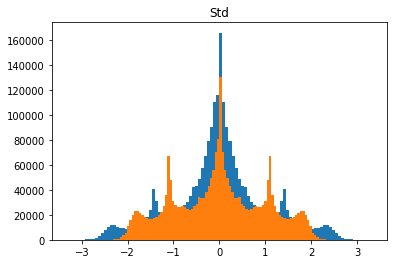

U
0.0
1.000000000000014
W
0.0
0.9999999999998797
Normalize in X and Y direction independently
Ynorm Index(['Up', 'Wp'], dtype='object')


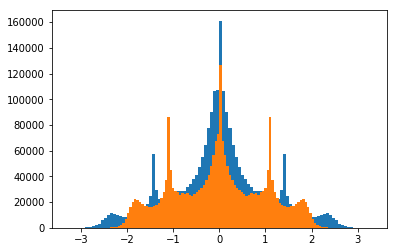

Standardized with:
Umean  0.0
Ustd   0.9109369802195609
Wmean  0.0
Wstd   0.7087137512219893


In [37]:
plt.title('Raw')
plt.hist(XtruthDf.W,bins=100,label='W')
plt.hist(XtruthDf.U,bins=100,label='U')
plt.legend()
plt.show()


Xstats = XtruthDf.U
Umean = Xstats.mean()
Ustd  = Xstats.std()


print('U')
print(Umean)
print(Ustd)

Ystats = XtruthDf.W 
Wmean = Ystats.mean()
Wstd  = Ystats.std()

print('W')
print(Wmean)
print(Wstd)



plt.title('Std')
Unorm=(XtruthDf.U-Xstats.mean())/(Xstats.std())
Wnorm=(XtruthDf.W-Wmean)/(Wstd)
plt.hist(Wnorm,bins=100)
plt.hist(Unorm,bins=100)
plt.show()

## Goal is to remove mean and deviation, thus avove is correct
# plt.title('Sqrt Norm')
# Unorm=(XtruthDf.U-Xstats.mean())/np.sqrt(Xstats.std())
# Wnorm=(XtruthDf.W-Wmean)/np.sqrt(Wstd)
# plt.hist(Wnorm,bins=100)
# plt.hist(Unorm,bins=100)
# plt.show()

print('U')
print(Unorm.mean())
print(Unorm.std())


print('W')
print(Wnorm.mean())
print(Wnorm.std())


print('Normalize in X and Y direction independently')


YnormDf = YtruthDf.copy()
XnormDf = XtruthDf.copy()

print("Ynorm",YnormDf.columns)

YnormDf.Up = (YtruthDf.Up-Umean)/Ustd
YnormDf.Wp = (YtruthDf.Wp-Wmean)/Wstd

XnormDf.U  = (XtruthDf.U  - Umean)/Ustd  
XnormDf.U0 = (XtruthDf.U0 - Umean)/Ustd  
XnormDf.U1 = (XtruthDf.U1 - Umean)/Ustd  
XnormDf.U2 = (XtruthDf.U2 - Umean)/Ustd  
XnormDf.U3 = (XtruthDf.U3 - Umean)/Ustd  
XnormDf.U4 = (XtruthDf.U4 - Umean)/Ustd  
XnormDf.U5 = (XtruthDf.U5 - Umean)/Ustd  
XnormDf.U6 = (XtruthDf.U6 - Umean)/Ustd  
XnormDf.U7 = (XtruthDf.U7 - Umean)/Ustd  

XnormDf.W  = (XtruthDf.W  - Wmean)/Wstd
XnormDf.W0 = (XtruthDf.W0 - Wmean)/Wstd
XnormDf.W1 = (XtruthDf.W1 - Wmean)/Wstd
XnormDf.W2 = (XtruthDf.W2 - Wmean)/Wstd
XnormDf.W3 = (XtruthDf.W3 - Wmean)/Wstd
XnormDf.W4 = (XtruthDf.W4 - Wmean)/Wstd
XnormDf.W5 = (XtruthDf.W5 - Wmean)/Wstd
XnormDf.W6 = (XtruthDf.W6 - Wmean)/Wstd
XnormDf.W7 = (XtruthDf.W7 - Wmean)/Wstd

plt.hist(XnormDf.W6,bins=100)
plt.hist(XnormDf.U6,bins=100)
plt.show()

print('Standardized with:')
print('Umean ',Umean)
print('Ustd  ',Ustd)
print('Wmean ',Wmean)
print('Wstd  ',Wstd)

f = open("stdfile.dat","w")
f.write("Umean Ustd Wmean Wstd \n")
f.write(str(Umean)+' '+str(Ustd)+' '+str(Wmean)+' '+str(Wstd))
f.close()


In [39]:
print(YtruthDf.values)

Ytruth = torch.tensor(YnormDf.values).float()
Xtruth = torch.tensor(XnormDf.values).float()
N     = Ytruth.size()[0]
D_out = Ytruth.size()[1]
D_in  = Xtruth.size()[1]

print('Batchsize ',N)
print('D_in      ',D_in)
print('D_out     ',D_out)

[[ 1.01497078 -0.01471513]
 [-1.01497078 -0.01471513]
 [ 1.01497078  0.01471513]
 ...
 [-2.07563019 -0.08793984]
 [ 0.08793984 -2.07563019]
 [-0.08793984  2.07563019]]
Batchsize  2455200
D_in       19
D_out      2


In [40]:
#creates copies, does not feed back to Xtruth
x = Xtruth
y = Ytruth


# works well, converges after 50000 epochs to 4.0e-6
# # H1, H2, H3 = 50, 8
# H1, H2, H3 = 100, 80, 20
# model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H1),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H1, H2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H2, H3),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H3, D_out),
# )



# #error = 6.8e-6 after 50000
# H1, H2, H3, H4 = 20, 20, 20, 10
# model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H1),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(H1, H2),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(H2, H3),
#     torch.nn.Softplus(),
#     torch.nn.Linear(H3, H4),
#     torch.nn.Softplus(),
#     torch.nn.Linear(H4, D_out),
# )


#error = 6.8e-6 after 50000
H1, H2 = 24, 16
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.Tanh(),
    torch.nn.Linear(H1, H2),
    torch.nn.Tanh(),
    torch.nn.Linear(H2, D_out),
)



# loss_fn = torch.nn.MSELoss(reduction='sum') # produces error, removed below
loss_fn = torch.nn.MSELoss()


In [ ]:
#TODO 
# - test on validation data to assess overfitting


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(4000):
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    print(t, loss.item())
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    
print('Done')

0 0.0012774330098181963
1 0.001239882200025022
2 0.0017692018300294876
3 0.0012785845901817083
4 0.0014580246061086655
5 0.0014899277593940496
6 0.0012983954511582851
7 0.0012201201170682907
8 0.0012989825336262584
9 0.0013400863390415907
10 0.0012629644479602575
11 0.0011787449475377798
12 0.001180786406621337
13 0.001231651403941214
14 0.0012310603633522987
15 0.0011720890179276466
16 0.0011299389880150557
17 0.0011417403584346175
18 0.0011676339199766517
19 0.0011582036968320608
20 0.0011202746536582708
21 0.0010952689917758107
22 0.0011027080472558737
23 0.0011179631110280752
24 0.0011075205402448773
25 0.0010773855028674006
26 0.0010622950503602624
27 0.0010724952444434166
28 0.0010789294028654695
29 0.0010618000524118543
30 0.0010402991902083158
31 0.0010376700665801764
32 0.0010448856046423316
33 0.0010395166464149952
34 0.0010228015016764402
35 0.001013074186630547
36 0.001014529843814671
37 0.0010137137724086642
38 0.0010034196311607957
39 0.0009924373589456081
40 0.0009891901

319 0.00036905112210661173
320 0.0003683203540276736
321 0.0003675906336866319
322 0.00036686332896351814
323 0.00036613858537748456
324 0.00036541547160595655
325 0.00036469317274168134
326 0.0003639716887846589
327 0.00036325177643448114
328 0.00036253390135243535
329 0.0003618178307078779
330 0.0003611030406318605
331 0.00036038938560523093
332 0.0003596768656279892
333 0.0003589658299461007
334 0.0003582565113902092
335 0.00035754882264882326
336 0.00035684247268363833
337 0.00035613737418316305
338 0.00035543349804356694
339 0.0003547308733686805
340 0.0003540297329891473
341 0.00035333013511262834
342 0.0003526319342199713
343 0.00035193521762266755
344 0.00035123981069773436
345 0.00035054603358730674
346 0.000349854031810537
347 0.0003491643292363733
348 0.00034847797360271215
349 0.00034779697307385504
350 0.00034712563501670957
351 0.00034647295251488686
352 0.0003458582505118102
353 0.00034532375866547227
354 0.0003449627256486565
355 0.00034497675369493663
356 0.00034579372

628 0.00021074811229482293
629 0.00021047891641501337
630 0.00021013294463045895
631 0.0002097323740599677
632 0.0002093208022415638
633 0.0002089393965434283
634 0.0002086102613247931
635 0.00020833608868997544
636 0.00020811059221159667
637 0.00020793179282918572
638 0.00020781408238690346
639 0.0002077914250548929
640 0.0002079215191770345
641 0.00020827879779972136
642 0.00020895508350804448
643 0.0002100256970152259
644 0.00021151505643501878
645 0.0002132573863491416
646 0.00021482695592567325
647 0.00021543557522818446
648 0.0002143897581845522
649 0.00021157547598704696
650 0.0002080037083942443
651 0.00020518792734947056
652 0.00020417661289684474
653 0.00020489025337155908
654 0.00020630958897527307
655 0.00020716022117994726
656 0.00020661522285081446
657 0.00020482482796069235
658 0.00020274992857594043
659 0.00020140557899139822
660 0.00020108696480747312
661 0.0002013086632359773
662 0.0002013452467508614
663 0.00020079425303265452
664 0.00019979961507488042
665 0.0001988

936 0.00013651984045282006
937 0.00013592604955192655
938 0.00013640332326758653
939 0.00013717953697778285
940 0.00013749132631346583
941 0.00013705129094887525
942 0.00013611488975584507
943 0.0001351777755189687
944 0.0001346017379546538
945 0.00013443329953588545
946 0.00013448136451188475
947 0.000134508271003142
948 0.00013438574387691915
949 0.0001341246097581461
950 0.00013381411554291844
951 0.000133533074404113
952 0.00013330891670193523
953 0.00013312255032360554
954 0.00013294117525219917
955 0.0001327461504843086
956 0.00013253992074169219
957 0.0001323405740549788
958 0.00013216702791396528
959 0.00013203133130446076
960 0.00013193261111155152
961 0.00013185905118007213
962 0.0001317933783866465
963 0.00013172293256502599
964 0.0001316516863880679
965 0.0001316031120950356
966 0.00013162301911506802
967 0.00013176952779758722
968 0.0001321153831668198
969 0.00013273832155391574
970 0.00013374096306506544
971 0.0001352385152131319
972 0.0001373835257254541
973 0.0001402772

1234 0.00010709201887948439
1235 0.00010942648077616468
1236 0.00011228469520574436
1237 0.0001153393168351613
1238 0.00011790022108471021
1239 0.00011888617882505059
1240 0.00011737733439076692
1241 0.00011326066305628046
1242 0.00010781147284433246
1243 0.00010305676551070064
1244 0.0001006050079013221
1245 0.00010075463069370016
1246 0.00010259725240757689
1247 0.00010470150300534442
1248 0.00010584193660179153
1249 0.00010550954175414518
1250 0.0001040176284732297
1251 0.00010221809498034418
1252 0.00010093070159200579
1253 0.00010054343874799088
1254 0.00010093200398841873
1255 0.00010168515291297808
1256 0.00010238222603220493
1257 0.00010280089918524027
1258 0.00010293369268765673
1259 0.00010294727690052241
1260 0.00010303399903932586
1261 0.00010336544073652476
1262 0.00010400796600151807
1263 0.00010492468572920188
1264 0.00010594432387733832
1265 0.0001067758203134872
1266 0.00010706877219490707
1267 0.00010654237121343613
1268 0.00010515086614759639
1269 0.00010319876309949

1537 8.211290696635842e-05
1538 8.206822531064972e-05
1539 8.20193745312281e-05
1540 8.19696142571047e-05
1541 8.192209497792646e-05
1542 8.187750063370913e-05
1543 8.183447789633647e-05
1544 8.17916079540737e-05
1545 8.174875983968377e-05
1546 8.170653745764866e-05
1547 8.16654646769166e-05
1548 8.162557787727565e-05
1549 8.158722630469128e-05
1550 8.155199611792341e-05
1551 8.152263762895018e-05
1552 8.150300709530711e-05
1553 8.149789937306195e-05
1554 8.151456131599844e-05
1555 8.156463445629925e-05
1556 8.166812767740339e-05
1557 8.185754268197343e-05
1558 8.218631410272792e-05
1559 8.273813728010282e-05
1560 8.364742825506255e-05
1561 8.511236956110224e-05
1562 8.742389763938263e-05
1563 9.091150423046201e-05
1564 9.587479871697724e-05
1565 0.00010211587505182251
1566 0.00010860632755793631
1567 0.00011275924771325663
1568 0.00011205097689526156
1569 0.00010573586769169196
1570 9.73287460510619e-05
1571 9.122453775489703e-05
1572 8.932032505981624e-05
1573 8.983273437479511e-05
1

In [42]:
torch.save(model, 'NNFDnormsym_5000.pt')

mod  tensor([ 9.0844e-01,  8.9480e-01,  8.8177e-01,  ...,  3.0408e-01,
         2.9060e-01,  2.8126e-01])


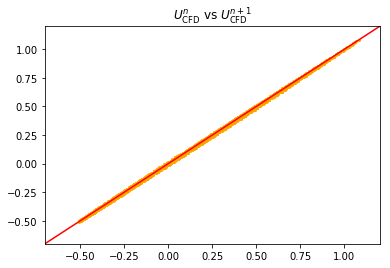

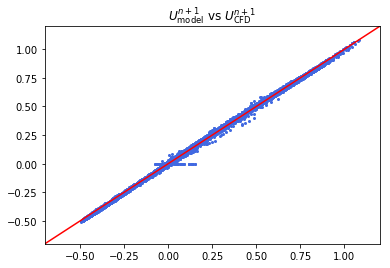

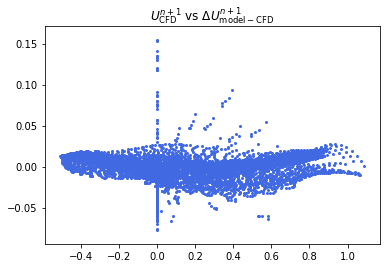

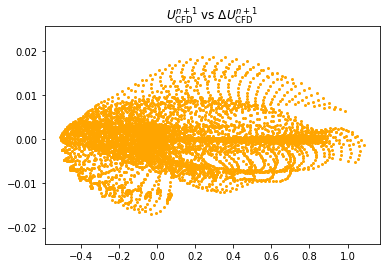

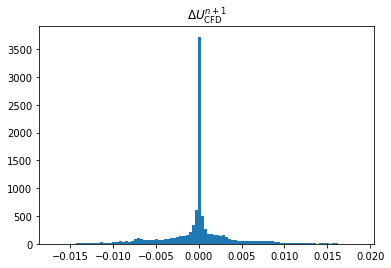

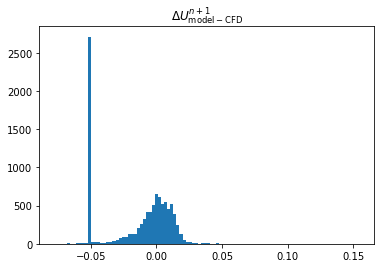

In [59]:
#compare training and test data


YtestDf = pd.read_csv("refdata.dat", sep = ' ',usecols=['Up','Wp'])
XtestDf = pd.read_csv("refdata.dat",sep=' ', usecols=['U','W','U0','W0','U1','W1',
                                                            'U2','W2','U3','W3','U4','W4',
                                                            'U5','W5','U6','W6','U7','W7',
                                                            'isfluid'])

Ytest = torch.tensor(YtestDf.values).float()
Xtest = torch.tensor(XtestDf.values).float()



#destandardize
#TODO: 
# - read normalization params
# - normalize input
# - call model with normalized input
# - denormalize model output


Y = model(Xtest)
Ymodel[:,0]



# for xline,yline,ytest in zip(x,y,ytest):
#     print xline[0],xline[1],yline[0],yline[1],ytest[0],test[1]


# print 'x   ',XtestDf.U,XtestDf.W

# print 'y   ',YtestDf.Up,YtestDf.Wp

print 'mod ',Ymodel[:,0]

REF = np.linspace(-0.7,1.2)
plt.scatter(XtestDf.U,YtestDf.Up,s=4,c='orange')
# plt.scatter(Ymodel[:,0].detach(),YtestDf.Up,s=4,c='royalblue')
plt.plot(REF,REF,c='red')
plt.title("$U_\mathrm{CFD}^{n}$ vs $U_\mathrm{CFD}^{n+1}$")
plt.xlim(-0.7,1.2)
plt.ylim(-0.7,1.2)
plt.show()



REF = np.linspace(-0.7,1.2)
# plt.scatter(XtestDf.U,YtestDf.Up,s=4,c='orange')
plt.scatter(Ymodel[:,0].detach(),YtestDf.Up,s=4,c='royalblue')
plt.plot(REF,REF,c='red')
plt.title("$U_\mathrm{model}^{n+1}$ vs $U_\mathrm{CFD}^{n+1}$")
plt.xlim(-0.7,1.2)
plt.ylim(-0.7,1.2)
plt.show()

# print Ymodel[:,0].detach()
# print YtestDf.Up

plt.title("$U_\mathrm{CFD}^{n+1}$ vs $\Delta U_\mathrm{model-CFD}^{n+1}$")
plt.scatter(YtestDf.Up,(Ymodel[:,0].detach()-torch.tensor(YtestDf.Up.values).float()),s=4,c='royalblue')
plt.show()

plt.title("$U_\mathrm{CFD}^{n+1}$ vs $\Delta U_\mathrm{CFD}^{n+1}$")
plt.scatter(YtestDf.Up,(XtestDf.U-YtestDf.Up),s=4,c='orange')
plt.show()

plt.title("$\Delta U_\mathrm{CFD}^{n+1}$")
plt.hist((XtestDf.U-YtestDf.Up),bins=100)
plt.show()

plt.title("$\Delta U_\mathrm{model-CFD}^{n+1}$")
plt.hist((Ymodel[:,0].detach()-torch.tensor(YtestDf.Up.values).float()),bins=100)
plt.show()

In [67]:
print Ymodel
print Ymodel[:,0]

tensor([[ 9.0844e-01, -1.9280e-01],
        [ 8.9480e-01, -1.8134e-01],
        [ 8.8177e-01, -1.6832e-01],
        ...,
        [ 3.0408e-01, -2.6851e-01],
        [ 2.9060e-01, -2.9449e-01],
        [ 2.8126e-01, -3.1776e-01]])
tensor([ 9.0844e-01,  8.9480e-01,  8.8177e-01,  ...,  3.0408e-01,
         2.9060e-01,  2.8126e-01])


In [8]:
torch.save(model, 'NNFD_norm_1.3e-3.pt')

In [9]:
model2 = torch.load('NNFD_norm_1.3e-3.pt')
model2.eval()

Sequential(
  (0): Linear(in_features=19, out_features=20, bias=True)
  (1): Softmax()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=10, bias=True)
  (5): Tanh()
  (6): Linear(in_features=10, out_features=2, bias=True)
)

In [10]:
Ymodel2 = model2(Xtest)

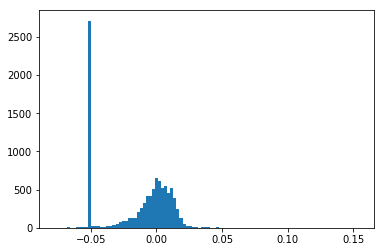

In [11]:
plt.hist((Ymodel2[:,0].detach()-torch.tensor(YtestDf.Up.values).float()),bins=100)
plt.show()

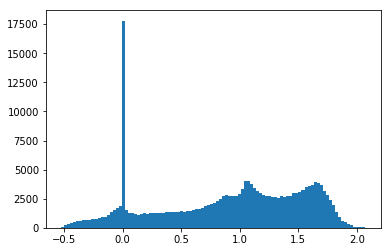

In [55]:

YnormDf.Up = (YtruthDf.Up-Umean)/Ustd
YnormDf.Wp = (YtruthDf.Wp-Wmean)/Wstd


# plt.hist(YnormDf.Wp,bins=100)
plt.hist(YtruthDf.Up,bins=100)
plt.show()